<a href="https://colab.research.google.com/github/anomaitech/GeoApp/blob/main/pysheds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pysheds
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rasterio 1.4.3 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
b

In [1]:
import rasterio
from pysheds.grid import Grid
from rasterio.plot import show
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

In [4]:
np.version.version

'1.23.5'

In [57]:
grid = Grid.from_raster('/content/drive/MyDrive/BYU/geospatial software development/gsl-pysheds.tif')
dem = grid.read_raster('/content/drive/MyDrive/BYU/geospatial software development/gsl-pysheds.tif')

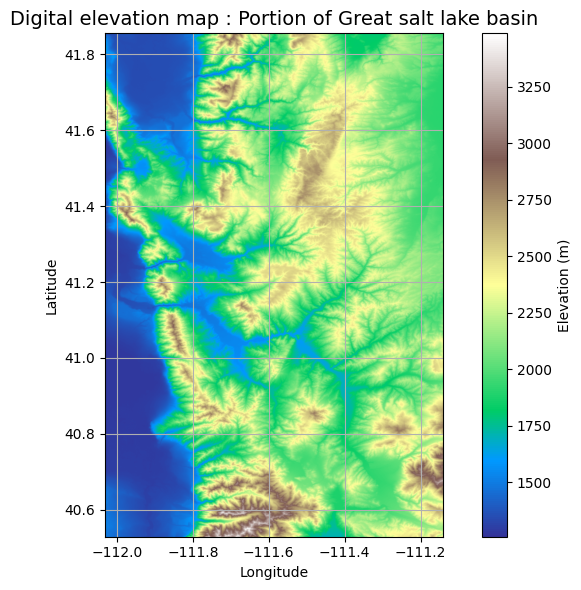

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map : Portion of Great salt lake basin', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [61]:
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [62]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

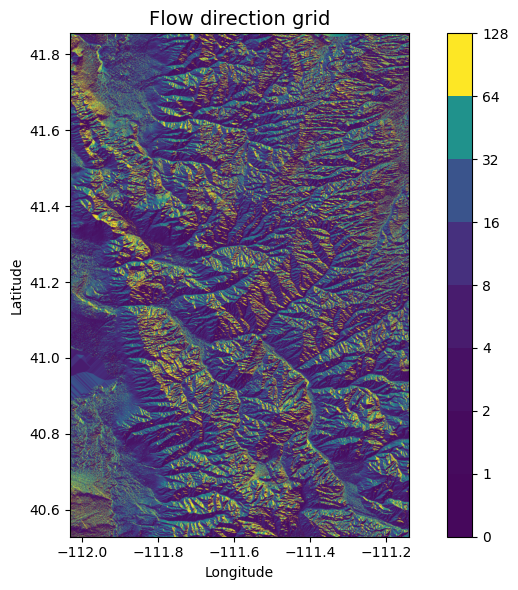

In [63]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [64]:
acc = grid.accumulation(fdir, dirmap=dirmap)


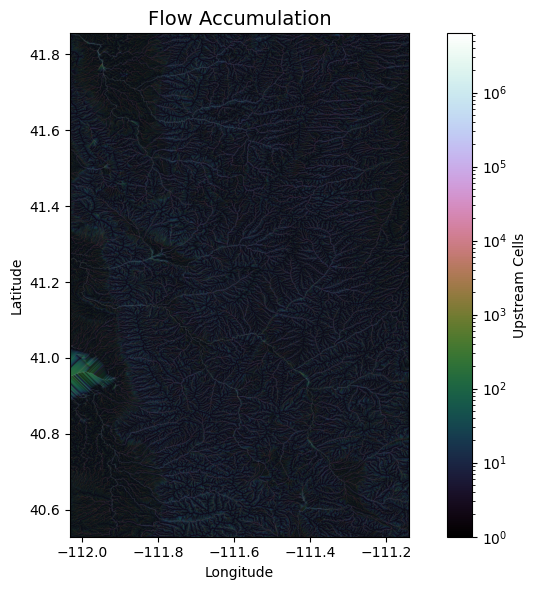

In [65]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [66]:
acc = grid.accumulation(fdir.astype(float), dirmap=dirmap,nodata_out=np.int64(-9999))


In [67]:
from pysheds.view import View, Raster
import numpy as np
x, y = -111.52, 41.05
def snap_to_mask(mask, xy, grid, return_dist=False, **kwargs):
    """
    Same docstring as above...
    """
    # Store original viewfinder nodata to restore later
    original_nodata = grid.viewfinder.nodata

    # If mask is not a Raster instance, create one
    if not isinstance(mask, Raster):
        if isinstance(mask, np.ndarray) and mask.dtype == np.bool_:
            nodata = False
            # Temporarily set viewfinder.nodata to False for boolean arrays
            grid.viewfinder.nodata = nodata
        else:
            nodata = -9999  # Adjust based on your data
        mask = Raster(mask, viewfinder=grid.viewfinder, metadata={'nodata': nodata})

    # Ensure mask is boolean and aligned with the grid
    mask_overrides = {'dtype': np.bool_, 'nodata': False}
    kwargs.update(mask_overrides)

    # Process mask using the grid's _input_handler


    # Get the affine transformation from the processed mask
    affine = mask.affine

    # Perform snapping using View.snap_to_mask
    result = View.snap_to_mask(mask, xy, affine=affine, return_dist=return_dist)

    # Restore original viewfinder nodata
    grid.viewfinder.nodata = original_nodata

    return result
x_snap, y_snap = snap_to_mask(acc > 1000, (x, y),grid)

Number of cells with accumulation above 1000: 333433


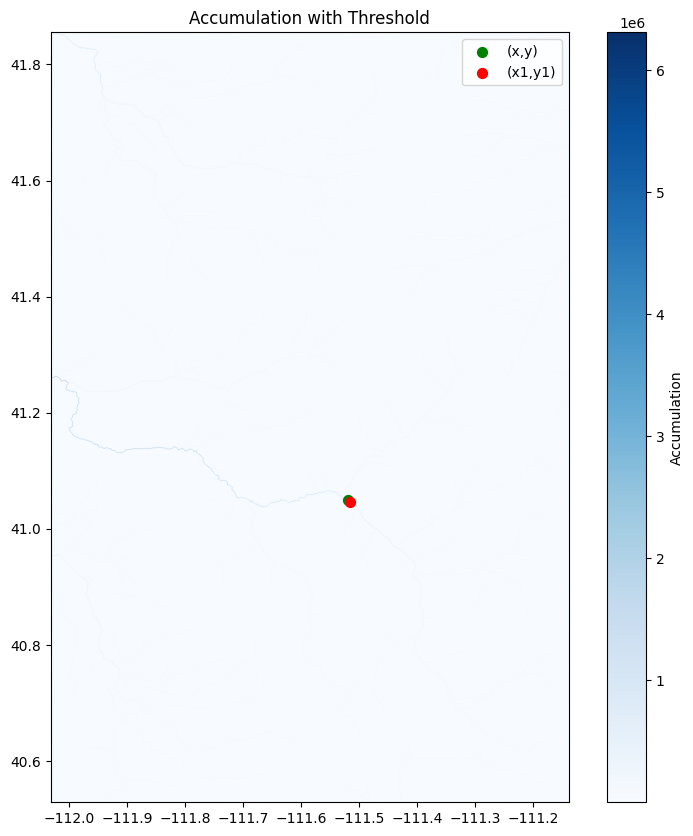

In [68]:

# Set a threshold for accumulation
threshold = 1000

# Find cells where accumulation exceeds the threshold
high_acc_cells = np.where(acc >= threshold)

# Get the coordinates of these cells
row_coords, col_coords = high_acc_cells

# Print coordinates or further process them as needed
print(f"Number of cells with accumulation above {threshold}: {len(row_coords)}")


# Visualization (optional):
fig, ax = plt.subplots(figsize=(10, 10))

# Display the accumulation
im = ax.imshow(acc,extent=grid.extent, cmap='Blues')

# Highlight cells above the threshold
x, y = x, y
x1,y1=x_snap,y_snap

ax.scatter(x,y, color='green', s=50, label='(x,y)')
ax.scatter(x1,y1, color='red', s=50, label='(x1,y1)')
plt.colorbar(im, ax=ax, label='Accumulation')
ax.set_title('Accumulation with Threshold')
ax.legend()

plt.show()


In [146]:
from pysheds.view import View ,Raster

In [69]:
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

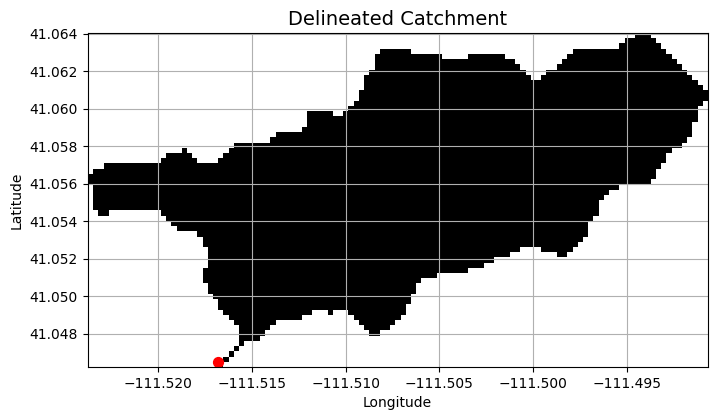

In [71]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
ax.scatter(x1,y1, color='red', s=50, label='(x1,y1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

In [74]:
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

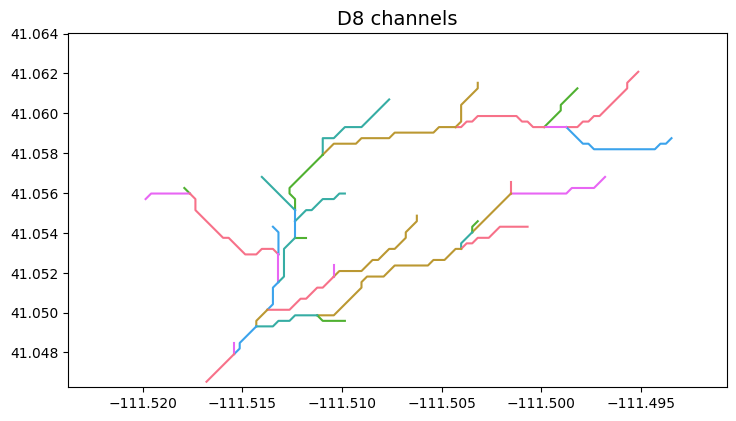

In [75]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('D8 channels', size=14)

In [28]:
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

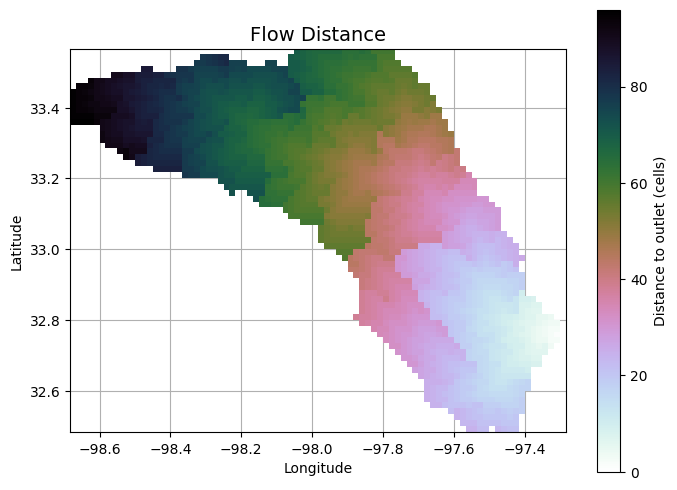

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

In [199]:
import inspect
print(inspect.getsource(grid.catchment))


    def catchment(self, x, y, fdir, pour_value=None, dirmap=(64, 128, 1, 2, 4, 8, 16, 32),
                  nodata_out=False, xytype='coordinate', routing='d8', snap='corner',
                  algorithm='iterative', **kwargs):
        """
        Delineates a watershed from a given pour point (x, y).

        Parameters
        ----------
        x : float or int
            x coordinate (or index) of pour point
        y : float or int
            y coordinate (or index) of pour point
        fdir : Raster
               Flow direction data.
        pour_value : int or None
                     If not None, value to represent pour point in catchment
                     grid.
        dirmap : list or tuple (length 8)
                 List of integer values representing the following
                 cardinal and intercardinal directions (in order):
                 [N, NE, E, SE, S, SW, W, NW]
        nodata_out : int or float
                     Value to indicate `no data` in outp

In [267]:
print(inspect.getsource(grid._mfd_catchment))

    def _mfd_catchment(self, x, y, fdir, pour_value=None, dirmap=(64, 128, 1, 2, 4, 8, 16, 32),
                       nodata_out=False, xytype='coordinate', snap='corner',
                       algorithm='iterative'):
        # Pad the rim
        left, right, top, bottom = self._pop_rim(fdir, nodata=0)
        # If xytype is 'coordinate', delineate catchment based on cell nearest
        # to given geographic coordinate
        if xytype in {'label', 'coordinate'}:
            x, y = self.nearest_cell(x, y, fdir.affine, snap)
        # Delineate the catchment
        if algorithm.lower() == 'iterative':
            catch = _self._mfd_catchment_iter_numba(fdir, (y, x))
        elif algorithm.lower() == 'recursive':
            raise NotImplementedError('Recursive algorithm not implemented.')
        else:
            raise ValueError('Algorithm must be `iterative` or `recursive`.')
        if pour_value is not None:
            catch[y, x] = pour_value
        # Create new mask becau

In [137]:
if mask.dtype == np.bool_:
    nodata = False
else:
    nodata = -9999

In [156]:
print(inspect.getsource(grid.))

TypeError: `nodata` value not representable in dtype of array.

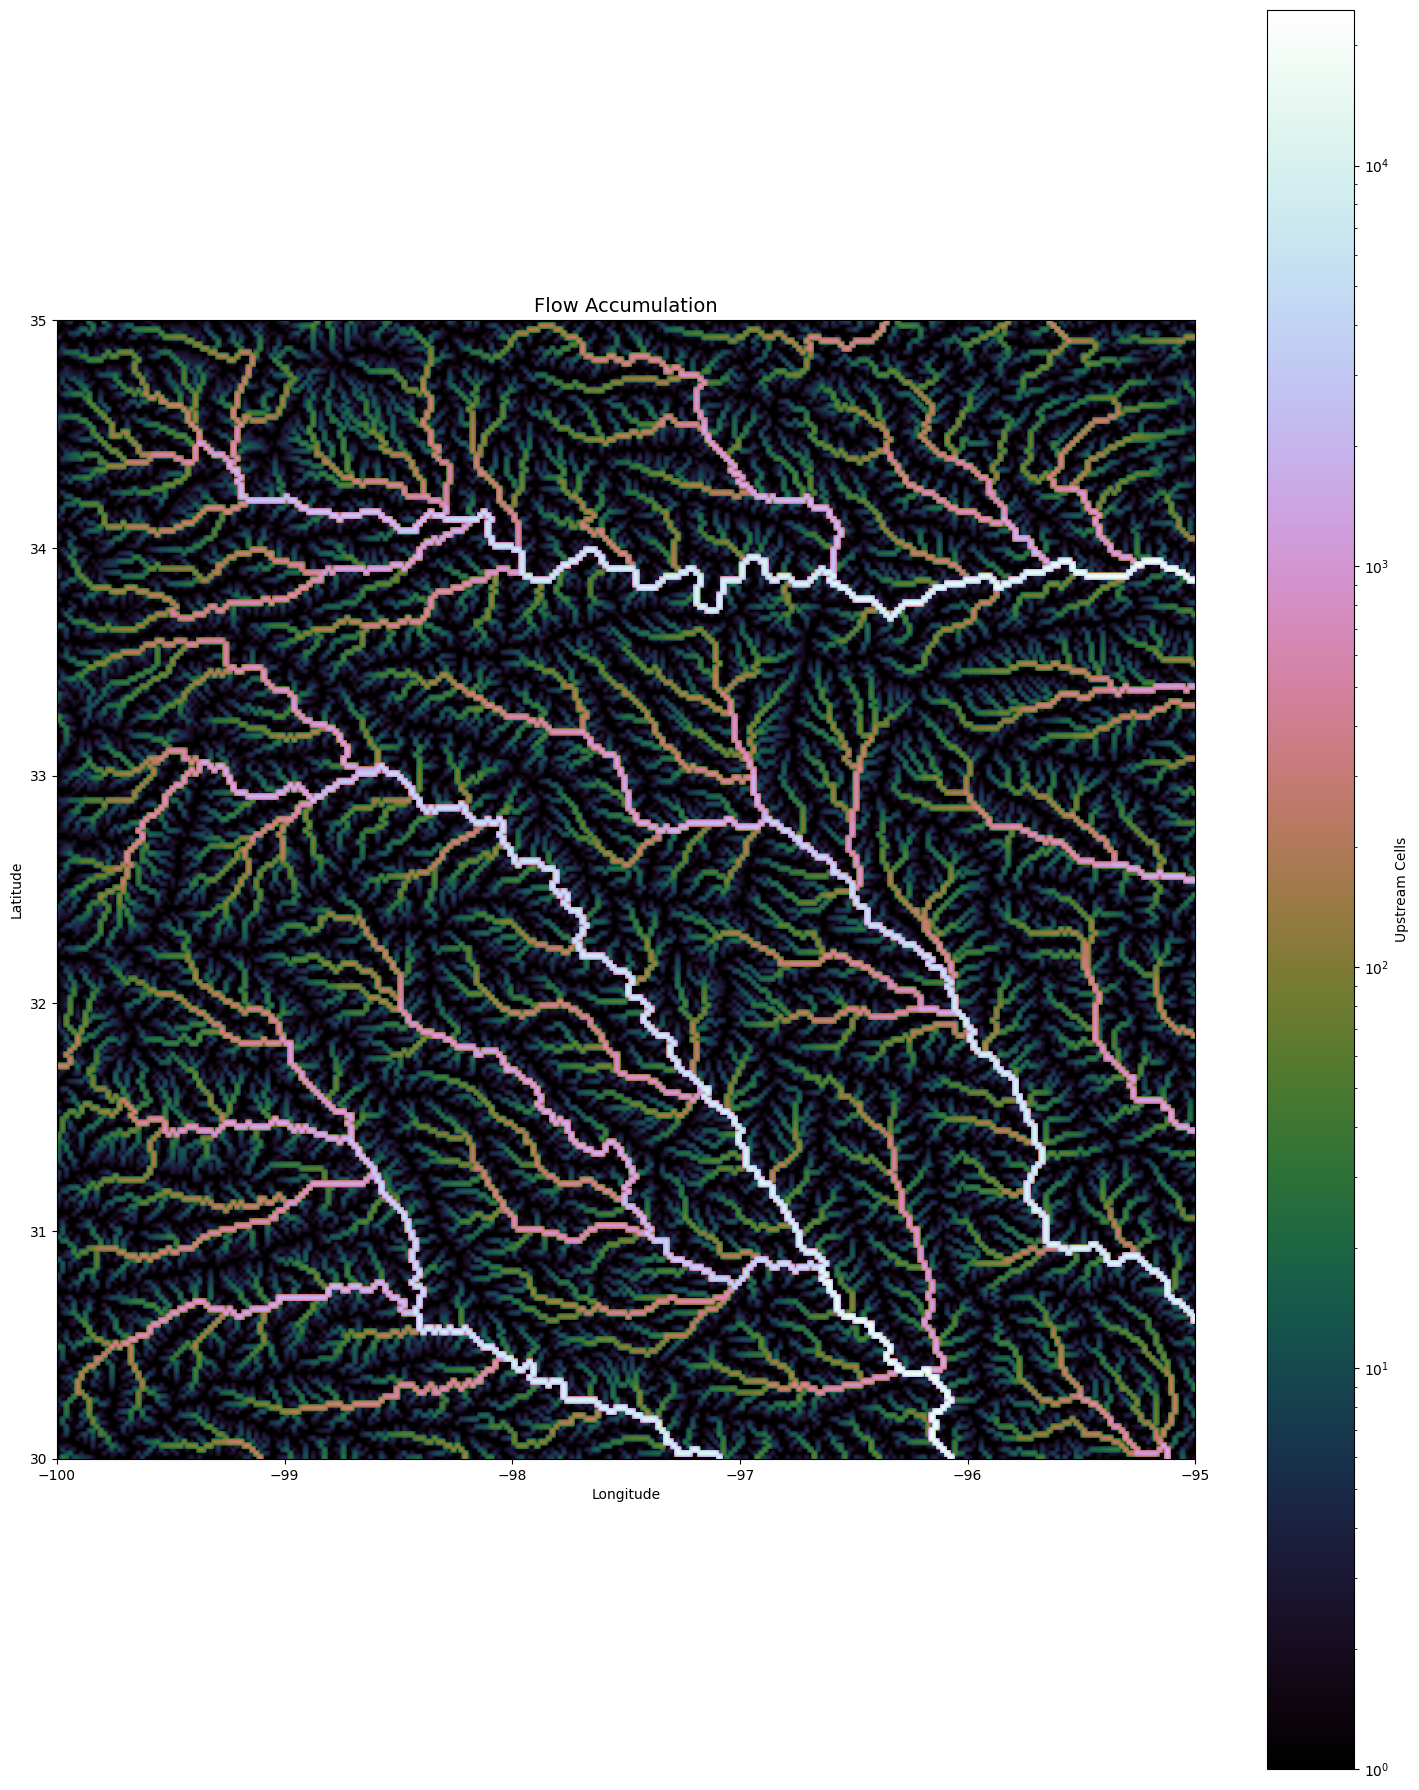

In [84]:
fig, ax = pyplot.subplots(figsize=(15,18))
fig.patch.set_alpha(0)
pyplot.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
pyplot.colorbar(im, ax=ax, label='Upstream Cells')
pyplot.title('Flow Accumulation', size=14)
pyplot.xlabel('Longitude')
pyplot.ylabel('Latitude')
pyplot.tight_layout()

In [ ]:
x, y = 321143, 7397199

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap)

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

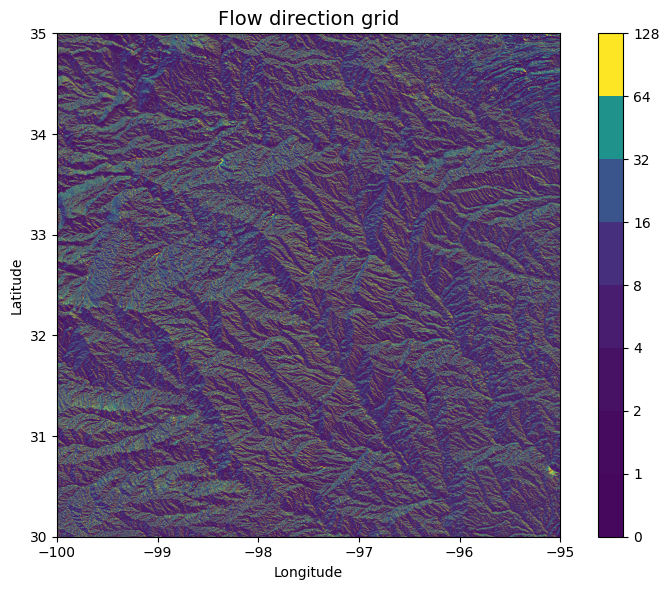

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
import numpy as np

# Use numpy types for nodata values, ensuring they are 64-bit
dem.nodata = np.int64(-9999)
grid.nodata = np.int64(-9999)

# Calculate flow direction with explicit 64-bit type handling
fdir = grid.flowdir(
    inflated_dem,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Must match array dtype
    dtype=np.int64  # Explicitly set output type to 64-bit
)

# Calculate accumulation with matching 64-bit types
acc = grid.accumulation(
    fdir,
    dirmap=dirmap,
    nodata_out=np.int64(-9999),  # Specify nodata_out with the correct type
    dtype=np.int64  # Must match flowdir's data type, use 64-bit
)


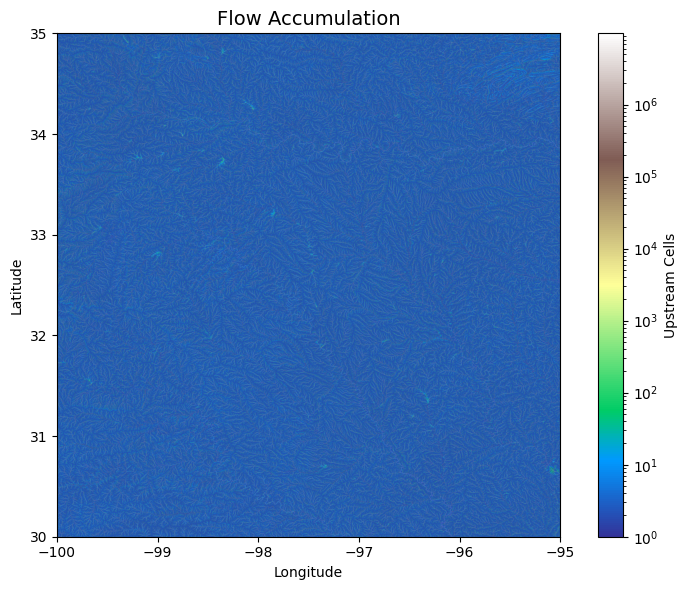

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)

# Try different colormaps, e.g., 'terrain', 'viridis', 'plasma', 'inferno'
cmap = 'terrain'

# Adjust normalization for better visualization
# You can try different vmin and vmax values or use a different normalization method like PowerNorm
norm = colors.LogNorm(vmin=1, vmax=acc.max())

im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap=cmap,
    norm=norm,
    interpolation='bilinear'
)

plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
x, y = -97.294, 32.737

def get_nodata(dtype):
    """Determine appropriate nodata value based on dtype."""
    if np.issubdtype(dtype, np.floating):
        return np.nan
    else:
        # For integer types, check if -9999 is valid, else use min/max
        if np.issubdtype(dtype, np.signedinteger):
            info = np.iinfo(dtype)
            return -9999 if info.min <= -9999 <= info.max else info.min
        else:  # Unsigned integer
            return np.iinfo(dtype).max

# Set nodata for accumulation grid (assuming `acc` is a numpy array)
acc.nodata = get_nodata(acc.dtype)

# Set nodata for sGrid using its underlying data (e.g., flow direction grid)
# Assuming `fdir` is the numpy array behind the `sGrid`
grid.nodata = get_nodata(fdir.dtype)  # Use dtype of the flow direction grid

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')

# Crop and plot the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

TypeError: `nodata` value not representable in dtype of array.